In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd

style.use('default')
import matplotlib.path as mpath

In [62]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['photoC_TOT_zint','zoo1C','zoo2C','zoo3C','zoo4C',
             'diatC','spC','coccoC',
             'x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_diat_zint','photoC_sp_zint','photoC_cocco_zint']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

#### get case

In [63]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004
photoC_TOT_zint
zoo1C
zoo2C
zoo3C
zoo4C
diatC
spC
coccoC
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
CPU times: user 9.27 s, sys: 1.39 s, total: 10.7 s
Wall time: 12.8 s


In [64]:
ds

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320, time: 61, z_t: 60, z_t_150m: 15)
Coordinates:
  * time               (time) object 0001-12-31 00:00:00 ... 0061-12-31 00:00:00
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t                (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, z_t_150m
Data variables:
    TAREA              (time, nlat, nlon) float64 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    KMT                (time, nlat, nlon) float64 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    dz                 (time, z_t) float32 dask.array<chunksize=(61, 60), meta=np.ndarray>
    photoC_TOT_zint    (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    zoo1C              (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    zoo2C              (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    zoo3C              (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    zoo4C              (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    diatC              (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    spC                (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    coccoC             (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    x_graze_zoo3_zint  (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    x_graze_zoo4_zint  (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    photoC_diat_zint   (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    photoC_sp_zint     (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    photoC_cocco_zint  (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>

In [65]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['HTLfood_zint'] = ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.x_graze_zoo3_zint / ds.photoC_TOT_zint
ds['zratio'] = tmp

tmp = (ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint) / ds.photoC_TOT_zint
ds['z2ratio'] = tmp

tmp = (ds.x_graze_zoo4_zint) / ds.photoC_TOT_zint
ds['zoo4ratio'] = tmp

tmp = (ds.photoC_diat_zint) / ds.photoC_TOT_zint
ds['diatNPPfrac'] = tmp

In [6]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1.e-4
depths=ds_grid.z_t * 0.01
tlen=len(ds.time)
years = np.arange(1958,1958+tlen,1)
years[2:61]

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

### plotting function (helps with South Pole stereographic map)

In [7]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [8]:
lons_norm=np.full((384, 320), np.nan)

lons_norm_firstpart = lons.where(lons<=180.)
lons_norm_secpart = lons.where(lons>180.) - 360.

lons_norm_firstpart = np.asarray(lons_norm_firstpart)
lons_norm_secpart = np.asarray(lons_norm_secpart)

lons_norm[~np.isnan(lons_norm_firstpart)] = lons_norm_firstpart[~np.isnan(lons_norm_firstpart)]
lons_norm[~np.isnan(lons_norm_secpart)] = lons_norm_secpart[~np.isnan(lons_norm_secpart)]

lons_norm=xr.DataArray(lons_norm)
lons_norm=lons_norm.rename({'dim_0':'nlat'})
lons_norm=lons_norm.rename({'dim_1':'nlon'})

In [9]:
variables = ['photoC_TOT_zint','zoo1C_zint','zoo2C_zint','zoo3C_zint','zoo4C_zint',
             'diatC_zint','spC_zint','x_graze_zoo3_zint','x_graze_zoo4_zint','photoC_diat_zint','photoC_sp_zint']

### Do correlations NPP and HTL vars

In [10]:
%%time
zoo4C_NPP_ann_corr = xr.corr(ds.zoo4C_zint, ds.photoC_TOT_zint, dim='time')
zoo4C_NPP_ann_corr = zoo4C_NPP_ann_corr.squeeze()

CPU times: user 977 ms, sys: 767 ms, total: 1.74 s
Wall time: 1.67 s


In [11]:
#box #1, subtropical atlantic
box1_latmin = 15.
box1_latmax = 30.
box1_lonmin = -45.
box1_lonmax = -30.

#box #2, subantarctic SO
box2_latmin = -50.
box2_latmax = -40.
box2_lonmin = -40.
box2_lonmax = -0.

#box #3, eq Pac
box3_latmin = -7.
box3_latmax = 4.
box3_lonmin = -105.
box3_lonmax = -85.

In [12]:
%%time
zoo4C_NPP_ann_corr2 = xr.corr(ds.zoo4C_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
zoo4C_NPP_ann_corr2 = zoo4C_NPP_ann_corr2.squeeze()

CPU times: user 897 ms, sys: 736 ms, total: 1.63 s
Wall time: 1.64 s


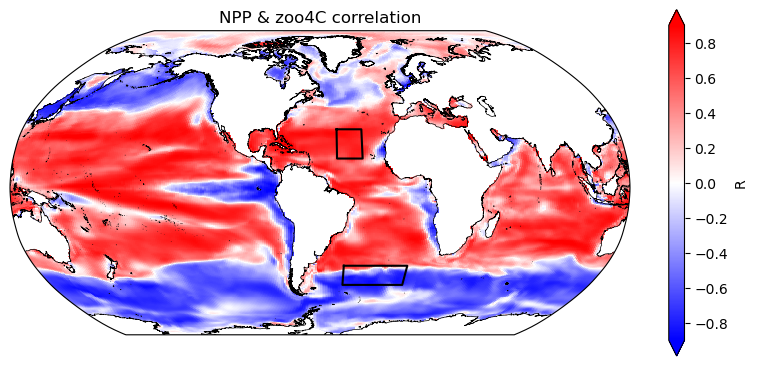

In [13]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4C_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo4C correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())

# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# # box3
# lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
# lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
# ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

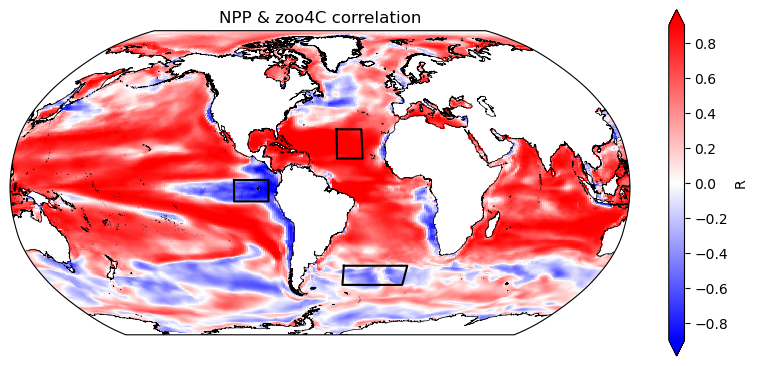

In [14]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4C_NPP_ann_corr2)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo4C correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())

# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

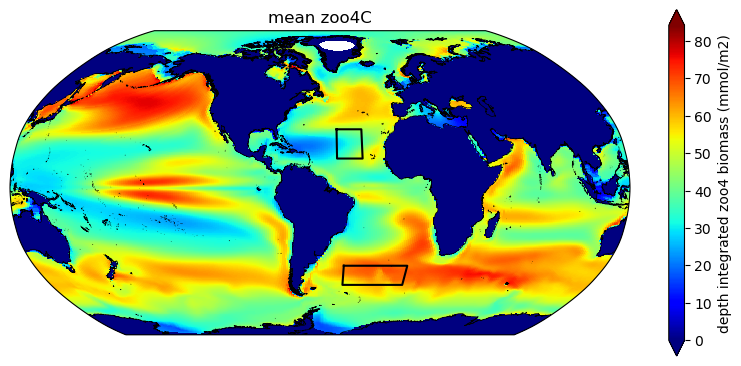

In [15]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.zoo4C_zint.mean(dim='time'))

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('mean zoo4C', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',
                 #vmin=-0.9,vmax=0.9,
                 transform=ccrs.PlateCarree())

# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='depth integrated zoo4 biomass (mmol/m2)')

In [16]:
ts_box1 = xr.Dataset({v: ds[v] for v in ['time']})

for var in variables:
    masked = ds[var].where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
    ts_box1[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

In [17]:
ts_box2 = xr.Dataset({v: ds[v] for v in ['time']})

for var in variables:
    masked = ds[var].where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
    ts_box2[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

In [18]:
for var in variables:
    mean = ts_box1[var].mean(dim='time').values
    stdev = np.std(ts_box1[var].values)
    
    mean2 = ts_box2[var].mean(dim='time').values
    stdev2 = np.std(ts_box2[var].values)    
    
    print('BOX1 ', var, ' mean is ',mean)
    print('BOX1 ', var, 'stdev is ',stdev)
    print('..........')
    print('BOX2 ', var, ' mean is ',mean2)
    print('BOX2 ', var, 'stdev is ',stdev2)
    print('------------------------')

BOX1  photoC_TOT_zint  mean is  0.036998519579403415
BOX1  photoC_TOT_zint stdev is  0.0018631375569788454
..........
BOX2  photoC_TOT_zint  mean is  0.04446584315783795
BOX2  photoC_TOT_zint stdev is  0.002282294618463987
------------------------
BOX1  zoo1C_zint  mean is  28.04636628358872
BOX1  zoo1C_zint stdev is  0.8961745678899583
..........
BOX2  zoo1C_zint  mean is  33.64942434637008
BOX2  zoo1C_zint stdev is  1.39226036057295
------------------------
BOX1  zoo2C_zint  mean is  58.51191395263365
BOX1  zoo2C_zint stdev is  2.0599933197191422
..........
BOX2  zoo2C_zint  mean is  75.27797511781431
BOX2  zoo2C_zint stdev is  6.588303818058322
------------------------
BOX1  zoo3C_zint  mean is  45.0382255735152
BOX1  zoo3C_zint stdev is  4.4674011654674315
..........
BOX2  zoo3C_zint  mean is  134.28860858143392
BOX2  zoo3C_zint stdev is  6.8448950688749886
------------------------
BOX1  zoo4C_zint  mean is  37.35621171429289
BOX1  zoo4C_zint stdev is  3.7238152954401103
..........

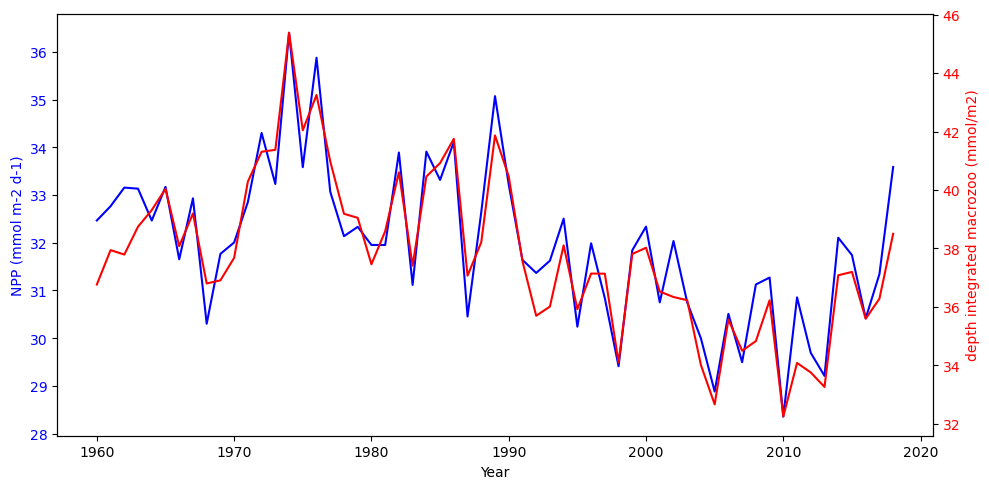

In [19]:
fig, ax1 = plt.subplots(figsize=(10,5))
#plt.title('WAP region standardized krill')
ax1.set_xlabel('Year')
ax1.set_ylabel('NPP (mmol m-2 d-1)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.plot(years[2:61], ts_box1['photoC_TOT_zint'].isel(time=slice(2,61))* 864., color='blue',label='NPP')

ax2 = ax1.twinx()

ax2.set_ylabel('depth integrated macrozoo (mmol/m2)', color='red')
ax2.plot(years[2:61], ts_box1['zoo4C_zint'].isel(time=slice(2,61)), color='red',label='macrozoo')
ax2.tick_params(axis='y', labelcolor='red')
#ax2.set_xticks(years)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [20]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box1['photoC_TOT_zint'].isel(time=slice(2,61)),ts_box1['zoo4C_zint'].isel(time=slice(2,61)))
np.round(r_value,decimals=2)

0.93

In [21]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box1['photoC_TOT_zint'].isel(time=slice(2,60)),ts_box1['zoo4C_zint'].isel(time=slice(3,61)))
np.round(r_value,decimals=2)

0.65

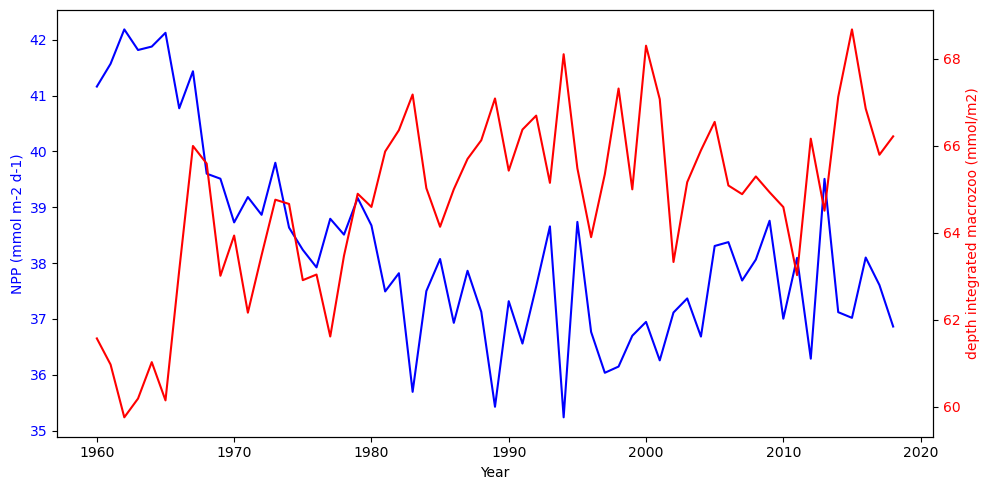

In [22]:
#style.use('ggplot')
style.use('default')
fig, ax1 = plt.subplots(figsize=(10,5))
#plt.title('WAP region standardized krill')
ax1.set_xlabel('Year')
ax1.set_ylabel('NPP (mmol m-2 d-1)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.plot(years[2:61], ts_box2['photoC_TOT_zint'].isel(time=slice(2,61))* 864., color='blue',label='NPP')

ax2 = ax1.twinx()

ax2.set_ylabel('depth integrated macrozoo (mmol/m2)', color='red')
ax2.plot(years[2:61], ts_box2['zoo4C_zint'].isel(time=slice(2,61)), color='red',label='macrozoo')
ax2.tick_params(axis='y', labelcolor='red')
#ax2.set_xticks(years)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

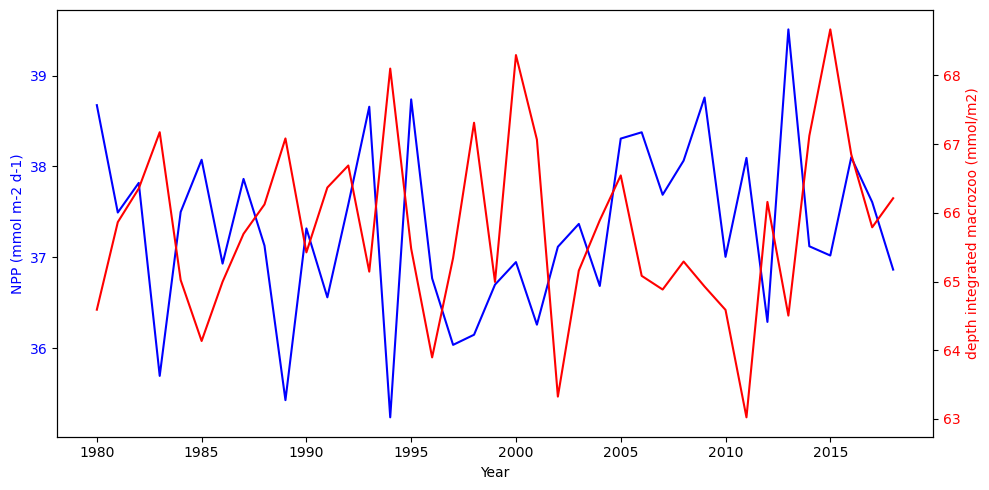

In [23]:
#style.use('ggplot')

fig, ax1 = plt.subplots(figsize=(10,5))
#plt.title('WAP region standardized krill')
ax1.set_xlabel('Year')
ax1.set_ylabel('NPP (mmol m-2 d-1)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.plot(years[22:61], ts_box2['photoC_TOT_zint'].isel(time=slice(22,61))* 864., color='blue',label='NPP')

ax2 = ax1.twinx()

ax2.set_ylabel('depth integrated macrozoo (mmol/m2)', color='red')
ax2.plot(years[22:61], ts_box2['zoo4C_zint'].isel(time=slice(22,61)), color='red',label='macrozoo')
ax2.tick_params(axis='y', labelcolor='red')
#ax2.set_xticks(years)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### BOX 2 lagged response to NPP?

In [24]:
### no lag
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box2['photoC_TOT_zint'].isel(time=slice(22,61)),ts_box2['zoo4C_zint'].isel(time=slice(22,61)))
np.round(r_value,decimals=2)

-0.47

In [25]:
### 1 year lag
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box2['photoC_TOT_zint'].isel(time=slice(22,60)),ts_box2['zoo4C_zint'].isel(time=slice(23,61)))
np.round(r_value,decimals=2)

0.04

In [26]:
### 2 year lag
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box2['photoC_TOT_zint'].isel(time=slice(22,59)),ts_box2['zoo4C_zint'].isel(time=slice(24,61)))
np.round(r_value,decimals=2)

0.05

### BOX 2 lagged response to zoo4C?

In [27]:
### 1 year lag
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box2['photoC_TOT_zint'].isel(time=slice(23,61)),ts_box2['zoo4C_zint'].isel(time=slice(22,60)))
np.round(r_value,decimals=2)

0.19

In [28]:
### 2 year lag
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box2['photoC_TOT_zint'].isel(time=slice(24,61)),ts_box2['zoo4C_zint'].isel(time=slice(22,59)))
np.round(r_value,decimals=2)

-0.12

In [29]:
### 3 year lag
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box2['photoC_TOT_zint'].isel(time=slice(25,61)),ts_box2['zoo4C_zint'].isel(time=slice(22,58)))
np.round(r_value,decimals=2)

-0.16

In [30]:
%%time
prodzoo4_NPP_ann_corr = xr.corr(ds.x_graze_zoo4_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
prodzoo4_NPP_ann_corr = prodzoo4_NPP_ann_corr.squeeze()

CPU times: user 159 ms, sys: 26.5 ms, total: 185 ms
Wall time: 151 ms


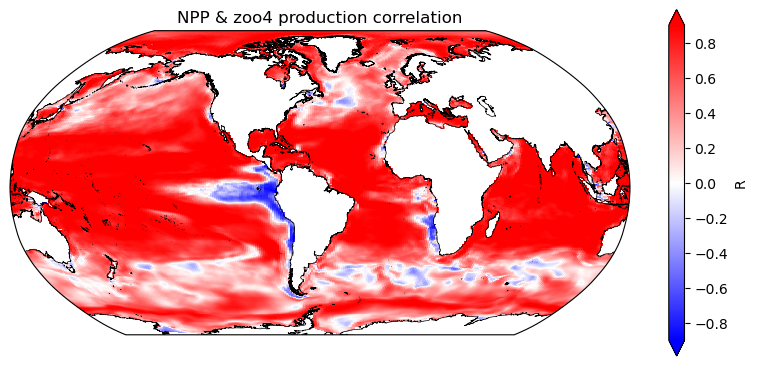

In [31]:
lon, lat, field = adjust_pop_grid(lons, lats, prodzoo4_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo4 production correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())

# # box1
# lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
# lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
# ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# # box2
# lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
# lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
# ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# # box3
# lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
# lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
# ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [32]:
%%time
zratio_NPP_ann_corr = xr.corr(ds.zratio.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
zratio_NPP_ann_corr = zratio_NPP_ann_corr.squeeze()

CPU times: user 178 ms, sys: 45.4 ms, total: 224 ms
Wall time: 179 ms


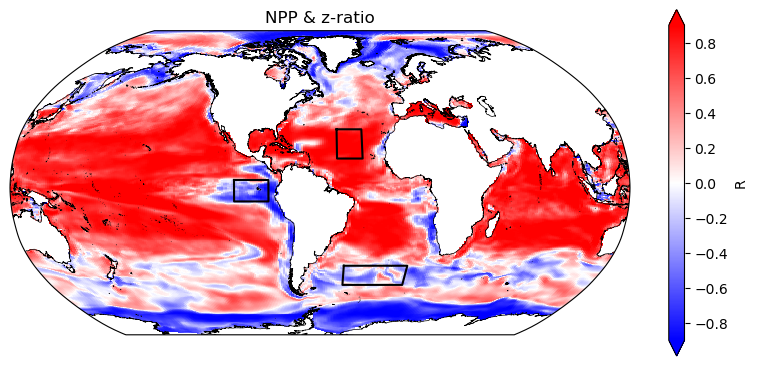

In [33]:
lon, lat, field = adjust_pop_grid(lons, lats, zratio_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & z-ratio', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/NPP_zratio_R_withboxes.png',dpi=300)

In [34]:
%%time
z2ratio_NPP_ann_corr = xr.corr(ds.z2ratio.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
z2ratio_NPP_ann_corr = z2ratio_NPP_ann_corr.squeeze()

CPU times: user 192 ms, sys: 73.3 ms, total: 265 ms
Wall time: 216 ms


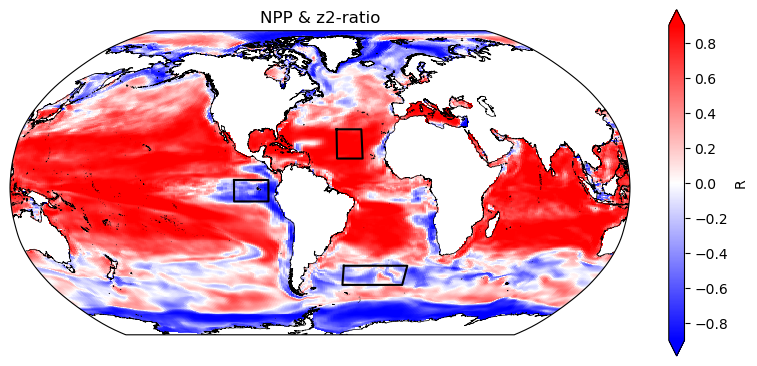

In [35]:
lon, lat, field = adjust_pop_grid(lons, lats, z2ratio_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & z2-ratio', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/NPP_z2ratio_R_withboxes.png',dpi=300)

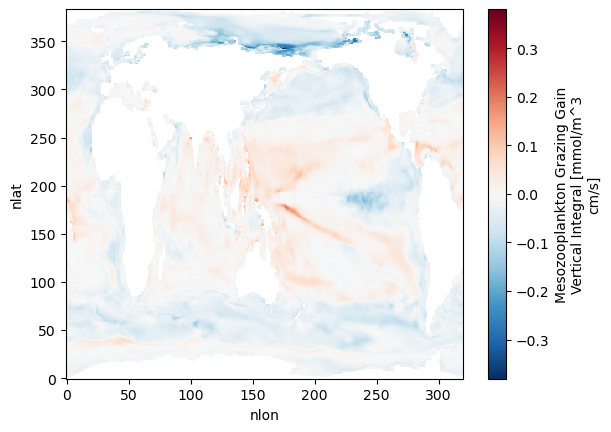

In [36]:
diff = z2ratio_NPP_ann_corr - zratio_NPP_ann_corr
diff.plot()

In [37]:
HTLfood_NPP_ann_corr = xr.corr(ds.HTLfood_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
HTLfood_NPP_ann_corr = HTLfood_NPP_ann_corr.squeeze()

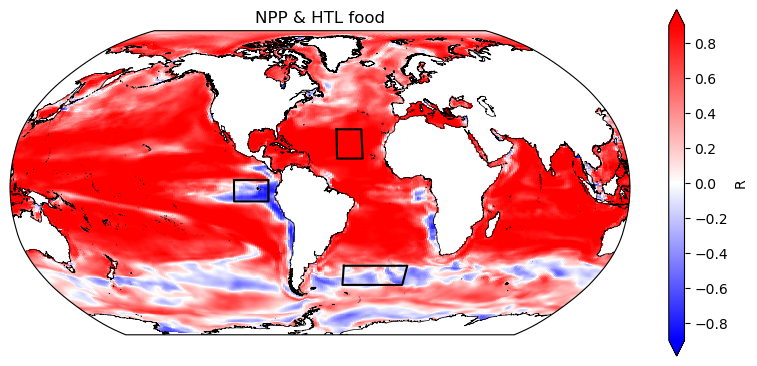

In [38]:
lon, lat, field = adjust_pop_grid(lons, lats, HTLfood_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & HTL food', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/NPP_HTLfood_R_withboxes.png',dpi=300)

In [39]:
%%time
zoo4ratio_NPP_ann_corr = xr.corr(ds.zoo4ratio.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
zoo4ratio_NPP_ann_corr = zoo4ratio_NPP_ann_corr.squeeze()

CPU times: user 314 ms, sys: 68.7 ms, total: 383 ms
Wall time: 337 ms


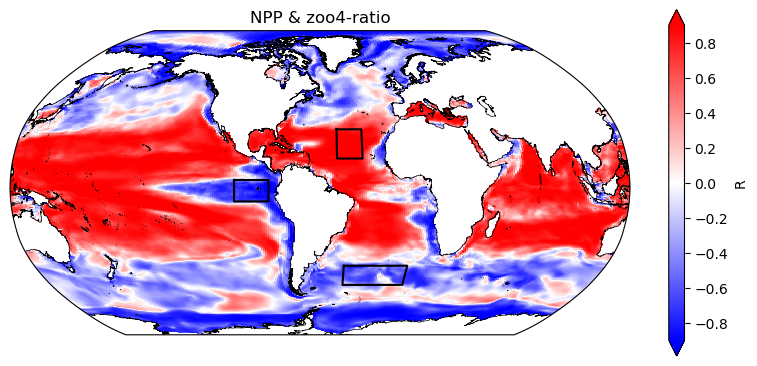

In [40]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4ratio_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo4-ratio', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/NPP_zoo4ratio_R_withboxes.png',dpi=300)

In [41]:
%%time
zoo3C_NPP_ann_corr = xr.corr(ds.zoo3C_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
zoo3C_NPP_ann_corr = zoo3C_NPP_ann_corr.squeeze()

CPU times: user 1.02 s, sys: 712 ms, total: 1.74 s
Wall time: 1.72 s


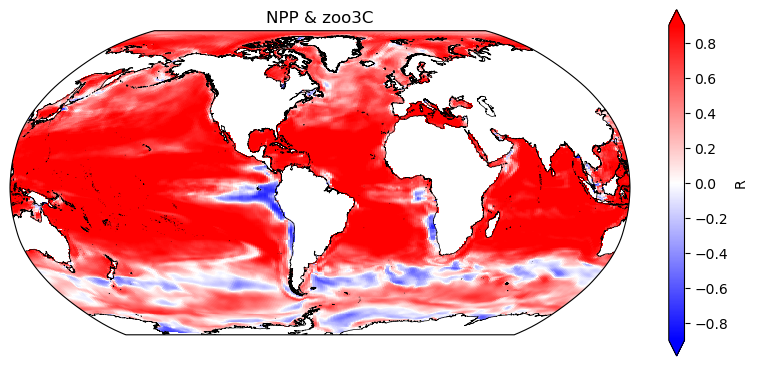

In [42]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo3C_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo3C', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### Correlations between NPP and other biomass/production

In [43]:
%%time
zoo2C_NPP_ann_corr = xr.corr(ds.zoo2C_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
zoo2C_NPP_ann_corr = zoo2C_NPP_ann_corr.squeeze()

CPU times: user 887 ms, sys: 697 ms, total: 1.58 s
Wall time: 1.7 s


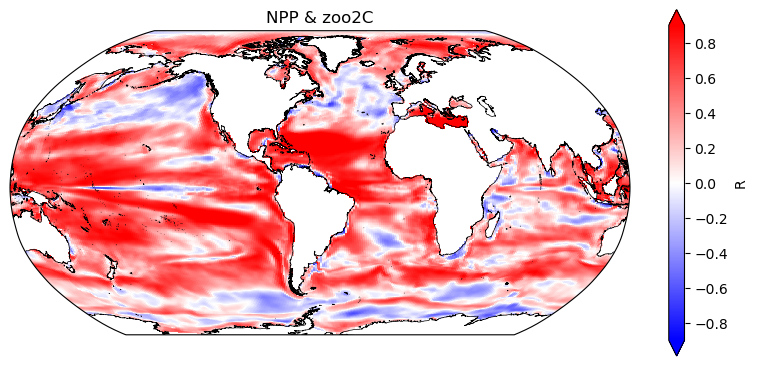

In [44]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo2C_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo2C', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [45]:
%%time
zoo1C_NPP_ann_corr = xr.corr(ds.zoo1C_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
zoo1C_NPP_ann_corr = zoo1C_NPP_ann_corr.squeeze()

CPU times: user 908 ms, sys: 699 ms, total: 1.61 s
Wall time: 1.69 s


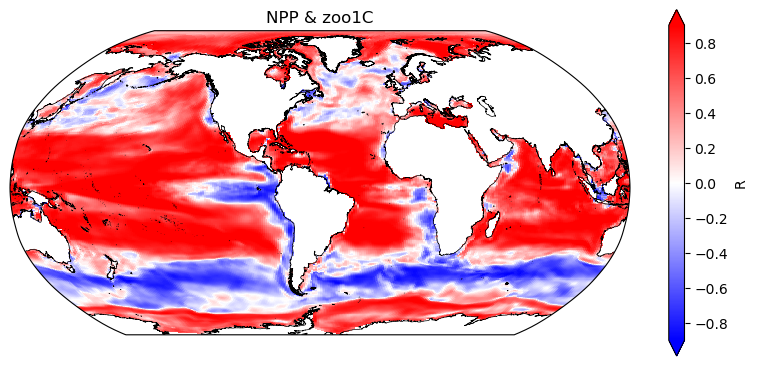

In [46]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo1C_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo1C', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [47]:
%%time
microzooC_NPP_ann_corr = xr.corr((ds.zoo1C_zint.isel(time=slice(22,61)) + ds.zoo2C_zint.isel(time=slice(22,61))), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
microzooC_NPP_ann_corr = microzooC_NPP_ann_corr.squeeze()

CPU times: user 2.48 s, sys: 1.69 s, total: 4.17 s
Wall time: 2.47 s


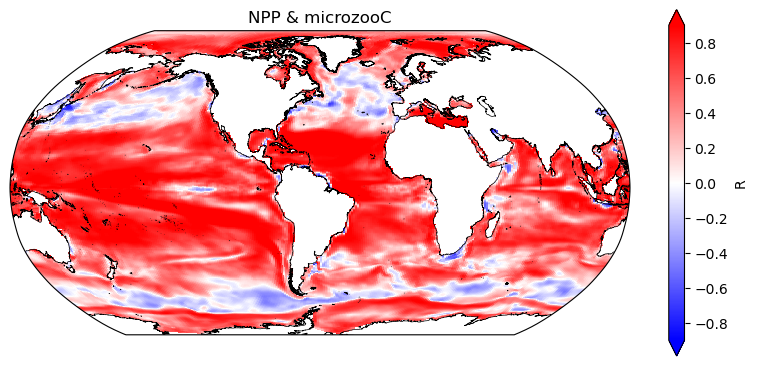

In [48]:
lon, lat, field = adjust_pop_grid(lons, lats, microzooC_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & microzooC', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [49]:
%%time
diatC_NPP_ann_corr = xr.corr(ds.diatC_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
diatC_NPP_ann_corr = diatC_NPP_ann_corr.squeeze()

CPU times: user 891 ms, sys: 704 ms, total: 1.59 s
Wall time: 1.72 s


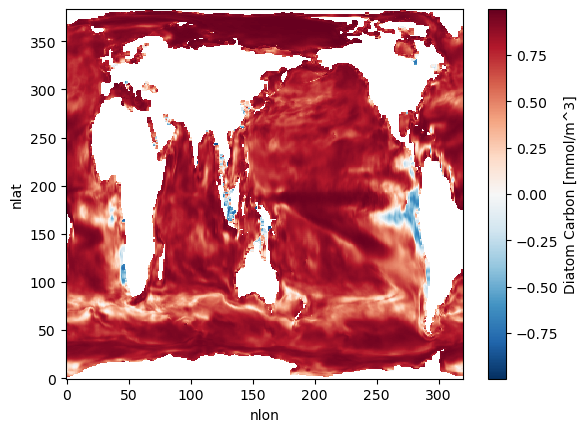

In [50]:
diatC_NPP_ann_corr.plot()

In [51]:
%%time
diatNPP_NPP_ann_corr = xr.corr(ds.photoC_diat_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
diatNPP_NPP_ann_corr = diatNPP_NPP_ann_corr.squeeze()

CPU times: user 300 ms, sys: 43.6 ms, total: 344 ms
Wall time: 427 ms


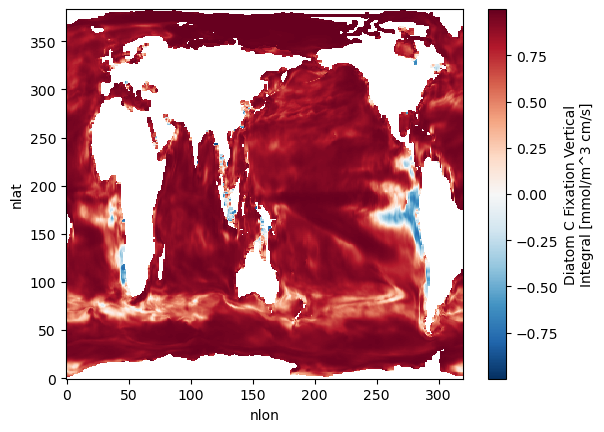

In [52]:
diatNPP_NPP_ann_corr.plot()

In [53]:
%%time
spNPP_NPP_ann_corr = xr.corr(ds.photoC_sp_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
spNPP_NPP_ann_corr = spNPP_NPP_ann_corr.squeeze()

CPU times: user 162 ms, sys: 22.3 ms, total: 184 ms
Wall time: 143 ms


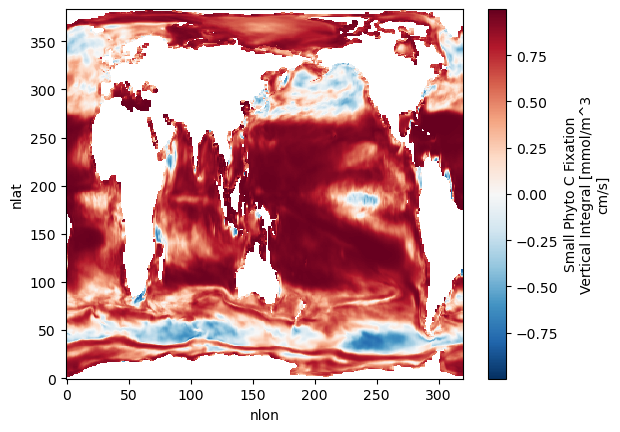

In [54]:
spNPP_NPP_ann_corr.plot()

In [55]:
%%time
diatNPPfrac_NPP_ann_corr = xr.corr(ds.diatNPPfrac.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
diatNPPfrac_NPP_ann_corr = diatNPPfrac_NPP_ann_corr.squeeze()

CPU times: user 221 ms, sys: 37.6 ms, total: 259 ms
Wall time: 257 ms


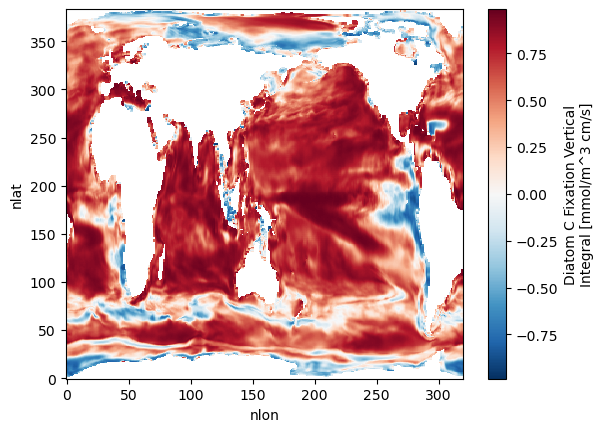

In [56]:
diatNPPfrac_NPP_ann_corr.plot()

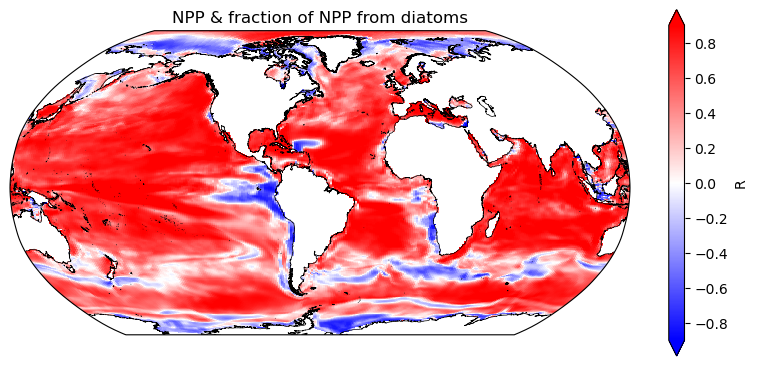

In [57]:
lon, lat, field = adjust_pop_grid(lons, lats, diatNPPfrac_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & fraction of NPP from diatoms', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')